<a href="https://colab.research.google.com/github/Anny-tech/Bayesian_Active_Learning/blob/main/BO_AL_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# @title This is a basic implementation of BO based Active Learning using the python based BoTorch package.

In [53]:

# @title Import Packages
from google.colab import drive
import subprocess
import sys
from typing import Tuple


'''Check which packages are already installed/ need to be installed and install
them automatically.'''

def install_package(package: str) -> None:
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

def check_and_install_packages(required_packages: dict) -> None:
    """Check and install missing packages."""
    for package, import_name in required_packages.items():
        try:
            __import__(import_name)
            print(f"{package} is already installed.")
        except ImportError:
            print(f"{package} is not installed. Installing now...")
            install_package(package)

if __name__ == "__main__":
    required_packages = {
        "torch": "torch",
        "botorch": "botorch",
        "pandas": "pandas",
        "matplotlib": "matplotlib.pyplot",
        "scikit-learn": "sklearn.metrics",
        "numpy": "numpy",
        "gpytorch": "gpytorch",
        "scikit-learn": "sklearn.preprocessing"
    }

    check_and_install_packages(required_packages)

# Import required packages
import torch
import pandas as pd
import numpy as np
import gpytorch
from sklearn.preprocessing import MinMaxScaler
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound, \
    qProbabilityOfImprovement, qSimpleRegret
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import os
import imageio
import random
import seaborn as sns

torch is already installed.
botorch is already installed.
pandas is already installed.
matplotlib is already installed.
scikit-learn is already installed.
numpy is already installed.
gpytorch is already installed.


In [54]:
# @title Specifies the device (either a GPU or a CPU) on which to perform computations. <br> torch.device -> PyTorch class that represents the device on which a tensor will be allocated or an operation will be performed. <br> ''cuda' if torch.cuda.is_available() else 'cpu'' -> Checks if CUDA enabled GPU is available for computation; otherwise use CPU.

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
# @title Utility Functions

# Set random seed for reproducibility
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Load dataset
def load_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df.drop(columns=['Folder Name'])
    return df

# Initialize data in tensor format
def initialize_tensors(df: pd.DataFrame) -> tuple:
    X_np = df[['Temperature_K', 'Strain', 'Shear_Strain']].values
    Y_np = df['Avg_twist_ang'].values
    X_i = torch.tensor(X_np, dtype=torch.float64).to(device)
    Y_org = torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device)
    return (X_i, Y_org, torch.tensor(X_np, dtype=torch.float64).to(device),
            torch.tensor(Y_np, dtype=torch.float64).unsqueeze(-1).to(device))

# Function to generate seed points at the beginning of each BO iteration
def initialize_samples(X_i: torch.Tensor, Y_org: torch.Tensor, \
                       num_samples: int) -> tuple:
    indices = torch.randperm(X_i.size(0))[:num_samples]
    X_init = X_i[indices]
    Y_init = Y_org[indices]
    return X_init, Y_init

# Initialization of GP model
def initialize_model(X: torch.Tensor, Y: torch.Tensor, \
                     kernel: gpytorch.kernels.Kernel) -> SingleTaskGP:
    gp_model = SingleTaskGP(X, Y, covar_module=kernel).to(device)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_mll(mll)
    return gp_model

# Random sampling function
def random_sampler(model: SingleTaskGP, X_i: torch.Tensor, batch_size: int, **kwargs) -> torch.Tensor:
    indices = torch.randperm(X_i.size(0))[:batch_size]
    return X_i[indices]

# Function for optimization of acquisition function
def optimize_acquisition_function(acq_func, gp_model: SingleTaskGP,
                                  Y_sample: torch.Tensor, bounds: torch.Tensor,
                                  batch_size: int, desired_target: float) -> torch.Tensor:
    if acq_func in [qExpectedImprovement, qProbabilityOfImprovement]:
        acq = acq_func(gp_model, best_f=torch.tensor(desired_target, dtype=torch.float64).to(device))
    else:
        acq = acq_func(gp_model, beta=0.1)
    candidates, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds,
        q=batch_size,
        num_restarts=5,
        raw_samples=20,
    )
    return candidates

# Function to rank acquisition functions for BO and kernels for GP
def rank_acquisition_kernels(acq_funcs: list, kernels: list, X_i: torch.Tensor,
                             Y_org: torch.Tensor, bounds: torch.Tensor,
                             desired_target: float) -> tuple:
    uncertainties = []
    for acq_func in acq_funcs:
        for kernel in kernels:
            gp_model = initialize_model(X_i, Y_org, kernel)
            if acq_func == random_sampler:
                candidates = random_sampler(gp_model, X_i, batch_size=5)
            else:
                acq = acq_func(gp_model, best_f=torch.tensor(desired_target, dtype=torch.float64).to(device)) if acq_func in [qExpectedImprovement, qProbabilityOfImprovement] else acq_func(gp_model, beta=0.1)
                candidates, _ = optimize_acqf(
                    acq_function=acq,
                    bounds=bounds,
                    q=5,
                    num_restarts=5,
                    raw_samples=20,
                )
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                observed_pred = gp_model.likelihood(gp_model(X_i))
                variance = observed_pred.variance
            uncertainty = torch.mean(variance).item()
            uncertainties.append((acq_func, kernel, uncertainty))
    return min(uncertainties, key=lambda x: x[2])


# Function to rank the unique candidates based on acquisition function values
def rank_candidates(acq_func, gp_model, candidates, best_f=None):
    individual_acq_values = []
    for point in candidates:
        if acq_func in [qExpectedImprovement, qProbabilityOfImprovement]:
            acq = acq_func(gp_model, best_f=best_f)
        elif acq_func == qUpperConfidenceBound:
            acq = acq_func(gp_model, beta=0.1)
        else:
            acq = acq_func(gp_model)

        with torch.no_grad():
            acq_value = acq(point.unsqueeze(0).to(device))
        individual_acq_values.append(acq_value.item())

    ranked_candidates = torch.stack([x for _, x in \
                                     sorted(zip(individual_acq_values, candidates), \
                                     key=lambda pair: pair[0], reverse=True)])
    ranked_values = sorted(individual_acq_values, reverse=True)
    return ranked_candidates, ranked_values

# Function to save ranked unique candidates from each iteration to .dat files
def save_rank_file(candidates: list, uncertainty: float, acq_func_name: str, \
                   iteration: int, ranked_candidates: list, ranked_values: list) -> None:
    rank_file_path = f'rank_{acq_func_name}_iter{iteration}.dat'
    with open(rank_file_path, 'w') as f:
        f.write('Ranked Candidates:\n')
        for candidate, value in zip(candidates, ranked_values):
            f.write(f"Candidate: {candidate}, Value: {value}\n")
        f.write('\nUncertainty:\n')
        f.write(str(uncertainty))

# Function to extract the Y value prediction from GP model post each BO iteration from the ranked unique candidates
def get_Y_next(candidates: torch.Tensor, gp_model: SingleTaskGP) -> torch.Tensor:
    gp_model.eval()
    candidates = candidates.to(device)  # Ensure candidates are on the same device
    with torch.no_grad():
        Y_next = gp_model(candidates).mean
    return Y_next.unsqueeze(-1)

# Function to augment original dataset after each BO loop
def update_samples(unique_candidates_tensor: torch.Tensor, X_org: torch.Tensor, \
                   Y_true: torch.Tensor, X_sample: torch.Tensor, Y_sample: torch.Tensor,\
                   Y_next: torch.Tensor) -> tuple:
    unique_candidates_tensor = unique_candidates_tensor.to(device)
    Y_next = Y_next.to(device)
    X_org = X_org.to(device)
    Y_true = Y_true.to(device)
    X_sample = X_sample.to(device)
    Y_sample = Y_sample.to(device)

    X_org = torch.cat([X_org, unique_candidates_tensor])
    Y_true = torch.cat([Y_true, Y_next])
    X_sample = torch.cat([X_sample, unique_candidates_tensor])
    Y_sample = torch.cat([Y_sample, Y_next])
    return X_org, Y_true, X_sample, Y_sample

# Function to calculate model uncertainty
def calculate_uncertainty(gp_model: SingleTaskGP, X_sample: torch.Tensor) -> float:
    X_sample = X_sample.to(device)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = gp_model.likelihood(gp_model(X_sample))
        variance = observed_pred.variance
    return torch.mean(variance).item()

# Prints iteration information post each BO iteration
def print_iteration_info(iteration: int, candidates: torch.Tensor,
                         Y_next: torch.Tensor, Y_sample: torch.Tensor,
                         Y_true: torch.Tensor, mse: float, uncertainty: float) -> None:
    print(f"Iteration {iteration + 1}: Candidates = {candidates}, \
            Y_next = {Y_next.cpu().numpy().flatten()}, MSE = {mse}, Uncertainty = {uncertainty}\n")

# Function calculate model performance -> to pull True Avg. Twist Angle values from MD simulations.
def MD_set_get(gp_model: SingleTaskGP, candidates: torch.Tensor, \
               Y_true: torch.Tensor) -> float:
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Get predictive distribution from the model
        pred_dist = gp_model.likelihood(gp_model(candidates))
        # Extract the mean and variance
        Y_pred = pred_dist.mean
        uncertainty = pred_dist.variance
    # Compute the difference between true values and predicted means
    prediction_error = (Y_pred - Y_true).abs()
    # Calculate weighted uncertainty by comparing prediction error with predicted variance
    weighted_uncertainty = (prediction_error / uncertainty).mean().item()

    return weighted_uncertainty

# Function to create a final dataframe of final augmented dataset
def create_results_dataframe(X_org: torch.Tensor, Y_true: torch.Tensor, \
                             performance: list, uncertainties: list) -> pd.DataFrame:
    return pd.DataFrame({
        'Temperature_K': X_org[:, 0].cpu().numpy(),
        'Strain': X_org[:, 1].cpu().numpy(),
        'Shear_Strain': X_org[:, 2].cpu().numpy(),
        'Objective_Value': Y_true.flatten().cpu().numpy()
    })

# Function to create 3D sampling evolution plots -> Gives a temporal sense of evolution of BO iterations
def plot_3d_scatter(X_i: torch.Tensor, unique_candidates: list, \
                    X_sample: torch.Tensor, title: str, Y_org: torch.Tensor) -> str:
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')

    X_i_np = X_i.cpu().numpy()
    Y_org_np = Y_org.cpu().numpy()

    # Plot original data points
    scatter = ax.scatter(X_i_np[:, 1], X_i_np[:, 2], X_i_np[:, 0], c=Y_org_np, \
                         cmap='viridis', marker='o', s=50, edgecolor='black', \
                         alpha=0.6, label='Ground truth (Avg. Twist Angles)')

    # Plot initial samples
    X_sample_np = X_sample.cpu().numpy()
    ax.scatter(X_sample_np[:, 1], X_sample_np[:, 2], X_sample_np[:, 0], c='g', \
               marker='^', alpha=1.0, s=100, label='Seed Points ')

    # Plot candidates
    if len(unique_candidates) > 0:
        candidates = np.array(unique_candidates).reshape(-1, 3)
        ax.scatter(candidates[:, 1], candidates[:, 2], candidates[:, 0], c='r',\
                   marker='d', alpha=1.0, s=180, label='Candidates')

    ax.set_xlabel('Strain')
    ax.set_ylabel('Shear_Strain')
    ax.set_zlabel('Temperature_K')
    ax.set_title(title)
    ax.legend()

    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('Average Twist Angle')

    # Increase vertical distance between legends
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', frameon=False, \
               numpoints=1, markerscale=1, handletextpad=0.5, labelspacing=1.0)

    plot_filename = f'{title}.png'
    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300)
    plt.close()
    return plot_filename

# Function to create .gif from images of BO iterations
def create_gif(plot_filenames: list, gif_filename: str, delay: float = 100.0) -> None:
    with imageio.get_writer(gif_filename, mode='I', duration=delay) as writer:
        for filename in plot_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            os.remove(filename)

# Define Bayesian Optimization Function
def bayesian_optimization(n_iterations: int, X_sample: torch.Tensor, \
                          Y_sample: torch.Tensor, X_i: torch.Tensor, \
                          Y_org: torch.Tensor, bounds: torch.Tensor, \
                          desired_target: float) -> pd.DataFrame:
    performance = []
    uncertainties = []
    batch_size = 5
    X_org = X_i.clone().detach().to(device)
    Y_true = Y_org.clone().detach().to(device)
    previous_candidates = set()
    plot_filenames = []

    #Declare list of acquisition functions and kernels to consider
    acq_funcs = [qExpectedImprovement, qUpperConfidenceBound, qProbabilityOfImprovement, random_sampler]
    kernels = [gpytorch.kernels.RBFKernel(), gpytorch.kernels.MaternKernel(), gpytorch.kernels.PeriodicKernel()]

    for i in range(n_iterations):
        best_acq_func, best_kernel, _ = rank_acquisition_kernels(acq_funcs, \
                                                                     kernels, \
                                                                     X_i, Y_org, \
                                                                     bounds, \
                                                                     desired_target)
        print(f'Iteration {i+1}: Best Acquisition Function: {best_acq_func.__name__}')
        print(f'Iteration {i+1}: Best Kernel: {best_kernel.__class__.__name__}')
        gp_model = initialize_model(X_sample, Y_sample, best_kernel)
        # Evaluation of acquisition functions starts here
        if best_acq_func == random_sampler:
            candidates = random_sampler(gp_model, X_sample, batch_size)
            ranked_candidates = candidates
            ranked_values = [0] * len(candidates)  # No ranking for random sampling
        else:
            candidates = optimize_acquisition_function(best_acq_func, gp_model, Y_sample, bounds, batch_size, desired_target=desired_target)
            ranked_candidates, ranked_values = rank_candidates(best_acq_func, gp_model, candidates, desired_target)  # Ranking of candidates done manually

        #candidates_closest = find_closest_values(ranked_candidates, X_i)
        # Check if the candidate is already in the previous candidates
        unique_candidates = []
        for candidate in ranked_candidates:
            candidate_tuple = tuple(candidate.cpu().numpy())
            if candidate_tuple not in previous_candidates:
                unique_candidates.append(candidate.cpu().numpy())
                previous_candidates.add(candidate_tuple)
        # Convert unique_candidates to a PyTorch tensor
        if unique_candidates:
            unique_candidates_tensor = torch.tensor(unique_candidates, dtype=torch.float64).to(device)
        #Dimension > 2 does not work properly during conversion to numpy array
        if unique_candidates_tensor.dim() > 2:
                unique_candidates_tensor = unique_candidates_tensor.squeeze()

        # Ensure unique_candidates_tensor is in the same device as other tensors
        if torch.cuda.is_available():
                unique_candidates_tensor = unique_candidates_tensor.to(device)
        else:
          print("No unique candidates found. Skipping update for this iteration.")
        #Dimension < 2 does not work properly during conversion to numpy array
        if unique_candidates_tensor.dim() < 2:
          unique_candidates_tensor = unique_candidates_tensor.unsqueeze(0)

        Y_next = get_Y_next(unique_candidates_tensor, gp_model)
        X_org, Y_true, X_sample, Y_sample = update_samples(unique_candidates_tensor, \
                                                               X_org, Y_true, \
                                                               X_sample, Y_sample, \
                                                               Y_next)

        # Calculate weighted uncertainty with respect to Y_true using MD_set_get
        #weighted_uncertainty = MD_set_get(gp_model, X_sample, Y_true[:len(X_sample)]) -> Pull parameters for MD here.
        #uncertainties.append(weighted_uncertainty)

        uncertainties.append(calculate_uncertainty(gp_model, X_sample))
        performance.append(mean_squared_error(Y_sample.cpu().numpy(), \
                                                  Y_true[:len(Y_sample)].cpu().numpy()))
        print_iteration_info(i, candidates, Y_next, Y_sample, Y_true, \
                                 performance[-1], uncertainties[-1])
        save_rank_file(unique_candidates, uncertainties[-1], \
                           best_acq_func.__name__, i, ranked_candidates, ranked_values)

        plot_filename = plot_3d_scatter(X_i, unique_candidates, X_sample, \
                                            f'Iteration_{i+1}', Y_org)
        plot_filenames.append(plot_filename)

    results_df = create_results_dataframe(X_org, Y_true, performance, uncertainties)
    create_gif(plot_filenames, 'bayesian_optimization.gif', delay=1000.0)
    return results_df


In [99]:
# @title BO execution:<br>Load Dataset:
drive.mount('/content/gdrive')
file_path = '/content/gdrive/MyDrive/Research/data_twist_angle_1.csv'
df = load_data(file_path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [100]:
df

,Temperature_K,Strain,Shear_Strain,Avg_twist_ang
0,1500,1.000,1.000,25.465624
1,500,1.000,1.000,12.641907
2,2500,1.000,1.000,0.188142
3,2500,1.015,1.000,8.608880
4,500,1.015,1.000,8.932990
5,500,1.035,1.000,6.923419
6,3500,1.000,1.000,12.233815
7,1500,1.035,1.000,11.091943
8,3500,1.015,1.000,8.035777
9,1500,1.015,1.000,25.829181


<Axes: xlabel='Avg_twist_ang', ylabel='Count'>

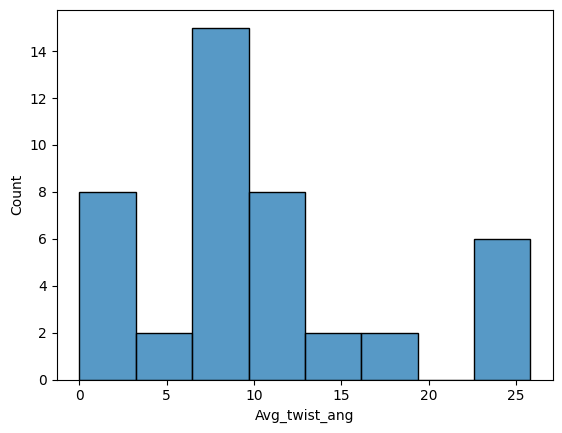

In [101]:
# @title Explore target value ('Avg_twist_ang') distribution

sns.histplot(data=df,x=df['Avg_twist_ang'])


In [102]:
# @title Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [103]:
# @title Data pre-processing
X_i, Y_org, X_org, Y_true = initialize_tensors(df)
X_i = X_i.to(device)
Y_org = Y_org.to(device)
X_org = X_org.to(device)
Y_true = Y_true.to(device)
bounds = torch.tensor([[500, 1.0, 1.0], [3500, 1.05, 1.05]],
                      dtype=torch.float64).to(device)
X_init, Y_init = initialize_samples(X_i, Y_org, num_samples=20)


In [104]:
# @title Run BO_AL
set_random_seed(42)
desired_value = 8.5

# Run Bayesian Optimization with the original format of data
results_df = bayesian_optimization(n_iterations=50, X_sample=X_init,\
                                       Y_sample=Y_init, X_i=X_i, Y_org=Y_org,\
                                       bounds=bounds, desired_target=desired_value)
results_df.to_csv('optimization_results.csv', index=False)

best_idx = torch.argmin(torch.abs(Y_init - torch.tensor(desired_value,
                                                            dtype=torch.float64)))
print("Optimization finished.")
print(f"Best location: {X_init[best_idx].cpu().numpy()}")
print(f"Best value: {Y_init[best_idx].cpu().numpy()}")

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 1: Best Acquisition Function: qUpperConfidenceBound
Iteration 1: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 1: Candidates = tensor([[2.8133e+03, 1.0000e+00, 1.0500e+00],
        [2.3811e+03, 1.0500e+00, 1.0000e+00],
        [3.4132e+03, 1.0500e+00, 1.0500e+00],
        [1.1328e+03, 1.0000e+00, 1.0000e+00],
        [1.3936e+03, 1.0000e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [10.94354598 10.93650524 10.93764906 10.89872117 10.89501591], MSE = 158.70586788553365, Uncertainty = 74.4684677653194



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 2: Best Acquisition Function: qProbabilityOfImprovement
Iteration 2: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 2: Candidates = tensor([[1.5975e+03, 1.0171e+00, 1.0153e+00],
        [1.9686e+03, 1.0465e+00, 1.0429e+00],
        [3.1749e+03, 1.0078e+00, 1.0323e+00],
        [1.9820e+03, 1.0321e+00, 1.0310e+00],
        [2.1078e+03, 1.0444e+00, 1.0073e+00]], dtype=torch.float64),             Y_next = [12.2462945  12.18344992 12.01081796 12.01788958 11.94360435], MSE = 140.21287799496497, Uncertainty = 41.82064064901144



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 3: Best Acquisition Function: qUpperConfidenceBound
Iteration 3: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 3: Candidates = tensor([[1.3171e+03, 1.0000e+00, 1.0500e+00],
        [1.1853e+03, 1.0000e+00, 1.0500e+00],
        [2.8588e+03, 1.0000e+00, 1.0500e+00],
        [2.7113e+03, 1.0500e+00, 1.0000e+00],
        [2.5024e+03, 1.0500e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [12.21397445 12.20608697 12.19466723 12.15316947 12.11707091], MSE = 127.33037046321273, Uncertainty = 37.68363897832325



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 4: Best Acquisition Function: qProbabilityOfImprovement
Iteration 4: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 4: Candidates = tensor([[2.4833e+03, 1.0315e+00, 1.0469e+00],
        [8.7995e+02, 1.0439e+00, 1.0292e+00],
        [1.4070e+03, 1.0441e+00, 1.0084e+00],
        [1.2478e+03, 1.0104e+00, 1.0270e+00],
        [3.1403e+03, 1.0027e+00, 1.0226e+00]], dtype=torch.float64),             Y_next = [13.20508607 11.89066316 11.94345669 11.83015006 11.40277131], MSE = 116.57979264923767, Uncertainty = 28.511649619241545



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 5: Best Acquisition Function: qProbabilityOfImprovement
Iteration 5: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 5: Candidates = tensor([[2.7927e+03, 1.0101e+00, 1.0309e+00],
        [2.9510e+03, 1.0375e+00, 1.0344e+00],
        [3.0037e+03, 1.0070e+00, 1.0295e+00],
        [9.7686e+02, 1.0283e+00, 1.0445e+00],
        [3.0704e+03, 1.0203e+00, 1.0424e+00]], dtype=torch.float64),             Y_next = [12.05360083 11.96956601 12.04921983 11.90022675 12.05208971], MSE = 111.26627366576243, Uncertainty = 24.339915428415132



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 6: Best Acquisition Function: qProbabilityOfImprovement
Iteration 6: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 6: Candidates = tensor([[1.3387e+03, 1.0489e+00, 1.0102e+00],
        [7.0468e+02, 1.0179e+00, 1.0483e+00],
        [2.2950e+03, 1.0106e+00, 1.0341e+00],
        [2.6535e+03, 1.0084e+00, 1.0439e+00],
        [3.4677e+03, 1.0062e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [12.15956463 12.09257345 12.14525027 12.15366166 10.86459584], MSE = 100.26423437530624, Uncertainty = 21.26230681400814



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 7: Best Acquisition Function: random_sampler
Iteration 7: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 7: Candidates = tensor([[3.5000e+03, 1.0000e+00, 1.0350e+00],
        [1.3171e+03, 1.0000e+00, 1.0500e+00],
        [7.0468e+02, 1.0179e+00, 1.0483e+00],
        [3.4677e+03, 1.0062e+00, 1.0000e+00],
        [1.2478e+03, 1.0104e+00, 1.0270e+00]], dtype=torch.float64),             Y_next = [10.58685793], MSE = 98.338027077517, Uncertainty = 26.353596966918513



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 8: Best Acquisition Function: qExpectedImprovement
Iteration 8: Best Kernel: PeriodicKernel


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.
Iteration 8: Candidates = tensor([[3.1171e+03, 1.0000e+00, 1.0000e+00],
        [3.4674e+03, 1.0500e+00, 1.0000e+00],
        [2.4433e+03, 1.0500e+00, 1.0000e+00],
        [9.0658e+02, 1.0000e+00, 1.0500e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [12.34385753 12.30484581 12.23354371 12.08017861 11.8082103 ], MSE = 89.56503064772083, Uncertainty = 22.208120962488938



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 9: Best Acquisition Function: qUpperConfidenceBound
Iteration 9: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 9: Candidates = tensor([[1.5910e+03, 1.0012e+00, 1.0186e+00],
        [9.8591e+02, 1.0454e+00, 1.0260e+00],
        [1.9672e+03, 1.0112e+00, 1.0087e+00],
        [1.0985e+03, 1.0494e+00, 1.0051e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00]], dtype=torch.float64),             Y_next = [14.36588986 12.0783296  12.08297377 12.05080047 10.80548726], MSE = 82.34621480484306, Uncertainty = 17.13231781663153



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 10: Best Acquisition Function: qExpectedImprovement
Iteration 10: Best Kernel: PeriodicKernel


/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


No unique candidates found. Skipping update for this iteration.
Iteration 10: Candidates = tensor([[7.2084e+02, 1.0000e+00, 1.0000e+00],
        [2.6926e+03, 1.0000e+00, 1.0000e+00],
        [2.6360e+03, 1.0000e+00, 1.0000e+00],
        [1.2694e+03, 1.0020e+00, 1.0309e+00],
        [2.9862e+03, 1.0500e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [14.3595915  14.3420683  12.17641514 12.12211048 12.12257414], MSE = 76.33636936213449, Uncertainty = 15.996056991153765



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 11: Best Acquisition Function: qProbabilityOfImprovement
Iteration 11: Best Kernel: PeriodicKernel
No unique candidates found. Skipping update for this iteration.
Iteration 11: Candidates = tensor([[3.4718e+03, 1.0375e+00, 1.0292e+00],
        [5.0744e+02, 1.0370e+00, 1.0303e+00],
        [3.1666e+03, 1.0338e+00, 1.0405e+00],
        [1.6390e+03, 1.0229e+00, 1.0160e+00],
        [3.0230e+03, 1.0238e+00, 1.0406e+00]], dtype=torch.float64),             Y_next = [12.09537534 12.22584206 12.2975357  12.0938546  10.91550614], MSE = 70.98309801430364, Uncertainty = 14.95483180947307



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 12: Best Acquisition Function: random_sampler
Iteration 12: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 12: Candidates = tensor([[3.5000e+03, 1.0000e+00, 1.0000e+00],
        [2.6360e+03, 1.0000e+00, 1.0000e+00],
        [5.0000e+02, 1.0550e+00, 1.0150e+00],
        [9.8591e+02, 1.0454e+00, 1.0260e+00],
        [1.5975e+03, 1.0171e+00, 1.0153e+00]], dtype=torch.float64),             Y_next = [10.79430009 10.8444393 ], MSE = 69.06367437252811, Uncertainty = 14.069956494399003



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 13: Best Acquisition Function: random_sampler
Iteration 13: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 13: Candidates = tensor([[5.0000e+02, 1.0350e+00, 1.0150e+00],
        [1.0985e+03, 1.0494e+00, 1.0051e+00],
        [3.1403e+03, 1.0027e+00, 1.0226e+00],
        [3.4132e+03, 1.0500e+00, 1.0500e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [10.81864447], MSE = 68.13110748914639, Uncertainty = 13.632505558031545



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 14: Best Acquisition Function: random_sampler
Iteration 14: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 14: Candidates = tensor([[7.0468e+02, 1.0179e+00, 1.0483e+00],
        [1.5000e+03, 1.0350e+00, 1.0000e+00],
        [1.5000e+03, 1.0000e+00, 1.0000e+00],
        [3.5000e+03, 1.0550e+00, 1.0000e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [14.82108653 14.82109635 10.74824064 11.840091  ], MSE = 64.82607566421439, Uncertainty = 13.416777517575156



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 15: Best Acquisition Function: random_sampler
Iteration 15: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 15: Candidates = tensor([[2.8133e+03, 1.0000e+00, 1.0500e+00],
        [1.5000e+03, 1.0000e+00, 1.0000e+00],
        [1.9672e+03, 1.0112e+00, 1.0087e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00],
        [1.3936e+03, 1.0000e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.82983663], MSE = 64.0054983481871, Uncertainty = 12.650825217128085



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 16: Best Acquisition Function: random_sampler
Iteration 16: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 16: Candidates = tensor([[5.0000e+02, 1.0350e+00, 1.0150e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [1.3171e+03, 1.0000e+00, 1.0500e+00],
        [1.5000e+03, 1.0000e+00, 1.0150e+00],
        [1.9820e+03, 1.0321e+00, 1.0310e+00]], dtype=torch.float64),             Y_next = [14.9420681], MSE = 63.20957938582973, Uncertainty = 12.469324842121281



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 17: Best Acquisition Function: random_sampler
Iteration 17: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 17: Candidates = tensor([[1.5000e+03, 1.0350e+00, 1.0150e+00],
        [3.1749e+03, 1.0078e+00, 1.0323e+00],
        [1.3171e+03, 1.0000e+00, 1.0500e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [8.7995e+02, 1.0439e+00, 1.0292e+00]], dtype=torch.float64),             Y_next = [14.96444039], MSE = 62.53204921452465, Uncertainty = 12.291484461209304



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 18: Best Acquisition Function: random_sampler
Iteration 18: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 18: Candidates = tensor([[1.9820e+03, 1.0321e+00, 1.0310e+00],
        [2.4833e+03, 1.0315e+00, 1.0469e+00],
        [1.5000e+03, 1.0350e+00, 1.0150e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00]], dtype=torch.float64),             Y_next = [14.98542944], MSE = 61.87219799082831, Uncertainty = 12.118399571635074



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 19: Best Acquisition Function: random_sampler
Iteration 19: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 19: Candidates = tensor([[1.5273e+03, 1.0352e+00, 1.0449e+00],
        [2.6926e+03, 1.0000e+00, 1.0000e+00],
        [1.0985e+03, 1.0494e+00, 1.0051e+00],
        [5.0000e+02, 1.0000e+00, 1.0150e+00],
        [1.9686e+03, 1.0465e+00, 1.0429e+00]], dtype=torch.float64),             Y_next = [10.71493269], MSE = 61.148250337148035, Uncertainty = 11.950872714865975



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 20: Best Acquisition Function: random_sampler
Iteration 20: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 20: Candidates = tensor([[1.5000e+03, 1.0350e+00, 1.0150e+00],
        [2.5024e+03, 1.0500e+00, 1.0000e+00],
        [1.2694e+03, 1.0020e+00, 1.0309e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [9.8591e+02, 1.0454e+00, 1.0260e+00]], dtype=torch.float64),             Y_next = [11.81742446], MSE = 60.43248565328135, Uncertainty = 11.789166351139476



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 21: Best Acquisition Function: random_sampler
Iteration 21: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 21: Candidates = tensor([[2.5000e+03, 1.0550e+00, 1.0000e+00],
        [5.0000e+02, 1.0350e+00, 1.0150e+00],
        [2.8133e+03, 1.0000e+00, 1.0500e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00],
        [2.4433e+03, 1.0500e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.81509768], MSE = 59.79768521990455, Uncertainty = 11.63183605000532



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 22: Best Acquisition Function: random_sampler
Iteration 22: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 22: Candidates = tensor([[1.9686e+03, 1.0465e+00, 1.0429e+00],
        [3.4132e+03, 1.0500e+00, 1.0500e+00],
        [2.2950e+03, 1.0106e+00, 1.0341e+00],
        [1.5910e+03, 1.0012e+00, 1.0186e+00],
        [1.6390e+03, 1.0229e+00, 1.0160e+00]], dtype=torch.float64),             Y_next = [11.81291127], MSE = 59.17674277906677, Uncertainty = 11.47747240412543



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 23: Best Acquisition Function: random_sampler
Iteration 23: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 23: Candidates = tensor([[1.3171e+03, 1.0000e+00, 1.0500e+00],
        [9.7686e+02, 1.0283e+00, 1.0445e+00],
        [5.0000e+02, 1.0350e+00, 1.0150e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.81085355], MSE = 58.49808637096321, Uncertainty = 11.326104646949089



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 24: Best Acquisition Function: random_sampler
Iteration 24: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 24: Candidates = tensor([[1.9686e+03, 1.0465e+00, 1.0429e+00],
        [5.0000e+02, 1.0550e+00, 1.0150e+00],
        [3.4677e+03, 1.0062e+00, 1.0000e+00],
        [3.4674e+03, 1.0500e+00, 1.0000e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00]], dtype=torch.float64),             Y_next = [11.80883872], MSE = 57.8344506076153, Uncertainty = 11.177863919458813



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 25: Best Acquisition Function: random_sampler
Iteration 25: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 25: Candidates = tensor([[2.5000e+03, 1.0350e+00, 1.0000e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.80701655], MSE = 57.185744158018686, Uncertainty = 11.032487875864733



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 26: Best Acquisition Function: random_sampler
Iteration 26: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 26: Candidates = tensor([[2.6535e+03, 1.0084e+00, 1.0439e+00],
        [1.5000e+03, 1.0000e+00, 1.0150e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00],
        [5.0744e+02, 1.0370e+00, 1.0303e+00],
        [3.1171e+03, 1.0000e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.80529595], MSE = 56.55128195685519, Uncertainty = 10.890085154219504



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 27: Best Acquisition Function: random_sampler
Iteration 27: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 27: Candidates = tensor([[7.0468e+02, 1.0179e+00, 1.0483e+00],
        [5.0000e+02, 1.0350e+00, 1.0150e+00],
        [2.5000e+03, 1.0150e+00, 1.0150e+00],
        [5.0744e+02, 1.0370e+00, 1.0303e+00],
        [1.5000e+03, 1.0350e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [11.80366521], MSE = 55.93179790561365, Uncertainty = 10.750624881034305



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 28: Best Acquisition Function: random_sampler
Iteration 28: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 28: Candidates = tensor([[3.0230e+03, 1.0238e+00, 1.0406e+00],
        [3.5000e+03, 1.0550e+00, 1.0000e+00],
        [8.7995e+02, 1.0439e+00, 1.0292e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [5.0744e+02, 1.0370e+00, 1.0303e+00]], dtype=torch.float64),             Y_next = [11.80212592], MSE = 55.326511307110415, Uncertainty = 10.61406907300375



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 29: Best Acquisition Function: random_sampler
Iteration 29: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 29: Candidates = tensor([[9.8591e+02, 1.0454e+00, 1.0260e+00],
        [5.0000e+02, 1.0550e+00, 1.0150e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00],
        [3.4132e+03, 1.0500e+00, 1.0500e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00]], dtype=torch.float64),             Y_next = [11.80066795], MSE = 54.73252686736968, Uncertainty = 10.480374781686693



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 30: Best Acquisition Function: random_sampler
Iteration 30: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 30: Candidates = tensor([[2.6926e+03, 1.0000e+00, 1.0000e+00],
        [1.5000e+03, 1.0000e+00, 1.0000e+00],
        [2.4433e+03, 1.0500e+00, 1.0000e+00],
        [5.0000e+02, 1.0000e+00, 1.0000e+00],
        [1.5000e+03, 1.0150e+00, 1.0350e+00]], dtype=torch.float64),             Y_next = [10.60689549 15.20723493], MSE = 53.786255085085386, Uncertainty = 10.34861532487551



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 31: Best Acquisition Function: random_sampler
Iteration 31: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 31: Candidates = tensor([[3.5000e+03, 1.0000e+00, 1.0350e+00],
        [1.5000e+03, 1.0150e+00, 1.0350e+00],
        [2.3811e+03, 1.0500e+00, 1.0000e+00],
        [5.0000e+02, 1.0000e+00, 1.0000e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [10.58972355 15.23951307], MSE = 52.87941435395875, Uncertainty = 10.100690699539234



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 32: Best Acquisition Function: random_sampler
Iteration 32: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 32: Candidates = tensor([[2.5000e+03, 1.0350e+00, 1.0000e+00],
        [2.8588e+03, 1.0000e+00, 1.0500e+00],
        [3.5000e+03, 1.0000e+00, 1.0000e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00],
        [5.0000e+02, 1.0550e+00, 1.0150e+00]], dtype=torch.float64),             Y_next = [10.57380581 15.26948799], MSE = 51.99539031272411, Uncertainty = 9.864072537823693



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 33: Best Acquisition Function: random_sampler
Iteration 33: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 33: Candidates = tensor([[1.9820e+03, 1.0321e+00, 1.0310e+00],
        [3.1666e+03, 1.0338e+00, 1.0405e+00],
        [7.5564e+02, 1.0000e+00, 1.0500e+00],
        [3.5000e+03, 1.0550e+00, 1.0000e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00]], dtype=torch.float64),             Y_next = [10.55905106 15.297341  ], MSE = 51.08447535886683, Uncertainty = 9.638173480499445



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 34: Best Acquisition Function: random_sampler
Iteration 34: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 34: Candidates = tensor([[3.4718e+03, 1.0375e+00, 1.0292e+00],
        [2.2950e+03, 1.0106e+00, 1.0341e+00],
        [1.5000e+03, 1.0350e+00, 1.0150e+00],
        [5.0000e+02, 1.0350e+00, 1.0350e+00],
        [2.6535e+03, 1.0084e+00, 1.0439e+00]], dtype=torch.float64),             Y_next = [10.54470015], MSE = 50.59983908839902, Uncertainty = 9.424722276764575



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 35: Best Acquisition Function: random_sampler
Iteration 35: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 35: Candidates = tensor([[2.8588e+03, 1.0000e+00, 1.0500e+00],
        [3.5000e+03, 1.0550e+00, 1.0000e+00],
        [5.0000e+02, 1.0000e+00, 1.0000e+00],
        [1.5273e+03, 1.0352e+00, 1.0449e+00],
        [2.6360e+03, 1.0000e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [10.53836592], MSE = 50.29685611553351, Uncertainty = 9.319257264723454



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 36: Best Acquisition Function: random_sampler
Iteration 36: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 36: Candidates = tensor([[5.0000e+02, 1.0550e+00, 1.0150e+00],
        [3.4677e+03, 1.0062e+00, 1.0000e+00],
        [3.0037e+03, 1.0070e+00, 1.0295e+00],
        [1.1853e+03, 1.0000e+00, 1.0500e+00],
        [5.0744e+02, 1.0370e+00, 1.0303e+00]], dtype=torch.float64),             Y_next = [10.53246402], MSE = 50.00210186968042, Uncertainty = 9.217019128814998



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 37: Best Acquisition Function: random_sampler
Iteration 37: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 37: Candidates = tensor([[3.4718e+03, 1.0375e+00, 1.0292e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [3.4132e+03, 1.0500e+00, 1.0500e+00],
        [2.5024e+03, 1.0500e+00, 1.0000e+00],
        [1.2478e+03, 1.0104e+00, 1.0270e+00]], dtype=torch.float64),             Y_next = [10.52680504], MSE = 49.71521834227034, Uncertainty = 9.116513700958041



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 38: Best Acquisition Function: random_sampler
Iteration 38: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 38: Candidates = tensor([[1.5000e+03, 1.0350e+00, 1.0150e+00],
        [5.0000e+02, 1.0350e+00, 1.0350e+00],
        [2.5000e+03, 1.0150e+00, 1.0150e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [2.8133e+03, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [10.52080321], MSE = 49.246562379165546, Uncertainty = 9.017761401028944



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 39: Best Acquisition Function: random_sampler
Iteration 39: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 39: Candidates = tensor([[1.5000e+03, 1.0150e+00, 1.0350e+00],
        [5.0000e+02, 1.0000e+00, 1.0150e+00],
        [1.0985e+03, 1.0494e+00, 1.0051e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [3.1403e+03, 1.0027e+00, 1.0226e+00]], dtype=torch.float64),             Y_next = [10.5158089], MSE = 48.80214780617535, Uncertainty = 8.921249625920316



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 40: Best Acquisition Function: random_sampler
Iteration 40: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 40: Candidates = tensor([[5.0000e+02, 1.0550e+00, 1.0150e+00],
        [3.4674e+03, 1.0500e+00, 1.0000e+00],
        [2.5000e+03, 1.0150e+00, 1.0350e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [2.4833e+03, 1.0315e+00, 1.0469e+00]], dtype=torch.float64),             Y_next = [10.51102816], MSE = 48.366022338680644, Uncertainty = 8.826258378244903



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 41: Best Acquisition Function: random_sampler
Iteration 41: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 41: Candidates = tensor([[1.5000e+03, 1.0350e+00, 1.0000e+00],
        [1.1853e+03, 1.0000e+00, 1.0500e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [1.1328e+03, 1.0000e+00, 1.0000e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [10.50590392], MSE = 47.93796954832574, Uncertainty = 8.732428627544305



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 42: Best Acquisition Function: random_sampler
Iteration 42: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 42: Candidates = tensor([[1.5910e+03, 1.0012e+00, 1.0186e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [3.1403e+03, 1.0027e+00, 1.0226e+00],
        [7.0468e+02, 1.0179e+00, 1.0483e+00]], dtype=torch.float64),             Y_next = [10.50166358], MSE = 47.51775144687379, Uncertainty = 8.641853128376061



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 43: Best Acquisition Function: random_sampler
Iteration 43: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 43: Candidates = tensor([[3.1749e+03, 1.0078e+00, 1.0323e+00],
        [5.0000e+02, 1.0350e+00, 1.0150e+00],
        [5.0000e+02, 1.0350e+00, 1.0350e+00],
        [1.5000e+03, 1.0000e+00, 1.0000e+00],
        [2.1078e+03, 1.0444e+00, 1.0073e+00]], dtype=torch.float64),             Y_next = [10.49752101], MSE = 47.10515507456131, Uncertainty = 8.551567781806094



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 44: Best Acquisition Function: random_sampler
Iteration 44: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 44: Candidates = tensor([[1.5000e+03, 1.0000e+00, 1.0000e+00],
        [1.4070e+03, 1.0441e+00, 1.0084e+00],
        [1.5000e+03, 1.0350e+00, 1.0000e+00],
        [5.0000e+02, 1.0350e+00, 1.0350e+00],
        [2.7113e+03, 1.0500e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [10.49310247], MSE = 46.69998735268989, Uncertainty = 8.46375853219038



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 45: Best Acquisition Function: random_sampler
Iteration 45: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 45: Candidates = tensor([[2.5000e+03, 1.0150e+00, 1.0150e+00],
        [2.7113e+03, 1.0500e+00, 1.0000e+00],
        [1.5000e+03, 1.0350e+00, 1.0150e+00],
        [5.0000e+02, 1.0000e+00, 1.0150e+00],
        [9.7686e+02, 1.0283e+00, 1.0445e+00]], dtype=torch.float64),             Y_next = [10.48944378], MSE = 46.302035844525484, Uncertainty = 8.377942708761903



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 46: Best Acquisition Function: random_sampler
Iteration 46: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 46: Candidates = tensor([[3.1749e+03, 1.0078e+00, 1.0323e+00],
        [3.4677e+03, 1.0062e+00, 1.0000e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [1.5000e+03, 1.0350e+00, 1.0150e+00],
        [5.0000e+02, 1.0350e+00, 1.0350e+00]], dtype=torch.float64),             Y_next = [10.48587496], MSE = 45.9111107154201, Uncertainty = 8.292710948544107



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 47: Best Acquisition Function: random_sampler
Iteration 47: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 47: Candidates = tensor([[1.5000e+03, 1.0150e+00, 1.0350e+00],
        [3.4674e+03, 1.0500e+00, 1.0000e+00],
        [1.3936e+03, 1.0000e+00, 1.0000e+00],
        [1.0985e+03, 1.0494e+00, 1.0051e+00],
        [3.4718e+03, 1.0375e+00, 1.0292e+00]], dtype=torch.float64),             Y_next = [10.48199735], MSE = 45.52703792184772, Uncertainty = 8.209980924758284



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 48: Best Acquisition Function: random_sampler
Iteration 48: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 48: Candidates = tensor([[1.3171e+03, 1.0000e+00, 1.0500e+00],
        [1.4070e+03, 1.0441e+00, 1.0084e+00],
        [2.8588e+03, 1.0000e+00, 1.0500e+00],
        [5.0000e+02, 1.0000e+00, 1.0150e+00],
        [3.0704e+03, 1.0203e+00, 1.0424e+00]], dtype=torch.float64),             Y_next = [10.47879762], MSE = 45.14962674300635, Uncertainty = 8.128628974391358



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 49: Best Acquisition Function: random_sampler
Iteration 49: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 49: Candidates = tensor([[3.5000e+03, 1.0000e+00, 1.0350e+00],
        [5.0000e+02, 1.0350e+00, 1.0150e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00],
        [5.0000e+02, 1.0550e+00, 1.0150e+00],
        [9.0658e+02, 1.0000e+00, 1.0500e+00]], dtype=torch.float64),             Y_next = [10.47534367], MSE = 44.76388041087284, Uncertainty = 8.04804778300122



/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([7.6233], dtype=torch.float64), mean = tensor([10.5669], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/usr/local/lib/python3.10/dist-packages/botorch/acquisition/monte_carlo.py:393: NumericsWarning: qExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qExpectedImprovement 	 --> 	 qLogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_na

Iteration 50: Best Acquisition Function: random_sampler
Iteration 50: Best Kernel: RBFKernel
No unique candidates found. Skipping update for this iteration.
Iteration 50: Candidates = tensor([[3.4132e+03, 1.0500e+00, 1.0500e+00],
        [7.2084e+02, 1.0000e+00, 1.0000e+00],
        [2.5000e+03, 1.0550e+00, 1.0000e+00],
        [2.8133e+03, 1.0000e+00, 1.0500e+00],
        [2.5000e+03, 1.0350e+00, 1.0000e+00]], dtype=torch.float64),             Y_next = [10.47243819], MSE = 44.574511086786174, Uncertainty = 7.970033780282475



<ipython-input-98-5fd6d6f0e73f>:239: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Optimization finished.
Best location: [2.500e+03 1.035e+00 1.000e+00]
Best value: [8.43504433]
